In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib  # For saving and loading the model
from scipy.stats import chisquare, pearsonr, linregress
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import pearsonr

In [34]:
# Read the manipulated dataset
df = pd.read_csv("mtcars_manipulated.csv")  # From Tuvshin manipulated data
mpg = df['mpg'].dropna().values 
hp = df['hp'].dropna().values

original_df = pd.read_csv("mtcars_original.csv")
original_mpg = original_df['mpg']
original_hp = original_df['hp']

In [37]:
# Benford expected distribution
def benford_distribution():
    return np.array([np.log10(1 + 1/d) for d in range(1, 10)])

# Extract first digit from numeric array
def extract_first_digit(array):
    first_digits = []
    for val in array:
        val_str = str(abs(val)).replace('.', '')
        if val_str and val_str[0].isdigit():
            first_digits.append(int(val_str[0]))
    return first_digits

# === Extract first digit from numeric array ===
def extract_first_digits(data):
    data = pd.Series(data).dropna()
    first_digits = data.astype(str).str.replace('.', '', regex=False).str.strip().str[0]
    return first_digits.astype(int)

# === Calculate Benford statistics: Chi-square, p-value, Euclidean Distance ===
def benford_stats(data):
    first_digits = extract_first_digits(data)
    observed_counts = first_digits.value_counts().sort_index()
    observed = observed_counts.reindex(range(1, 10), fill_value=0).values
    expected = benford_distribution() * observed.sum()

    chi2, pval = chisquare(f_obs=observed, f_exp=expected)
    euclidean_dist = np.linalg.norm(observed / observed.sum() - benford_distribution())

    return chi2, pval, euclidean_dist

def synthesize_benford_mpg(n_samples=1000, min_val=15, max_val=40, noise_std=0.1, seed=2):
    np.random.seed(seed)  # Set the seed for reproducibility
    samples = []
    while len(samples) < n_samples:
        digit = np.random.choice(benford_digits, p=benford_probs)
        exponent = np.random.uniform(1.3, 1.5)  # Control scale
        noise = np.random.normal(0, noise_std)
        value = digit * 10 ** exponent + noise
        if min_val <= value <= max_val:
            samples.append(value)
    return np.array(samples[:n_samples]) 

# --- Reverse predicted_mpg using the same logic ---
def reverse_predictions(y_pred, noise_std=2.3, seed=5):
    np.random.seed(seed)
    
    y_mean = np.mean(y_pred)
    y_inv = 2 * y_mean - y_pred  # mirror around mean
    noise = np.random.normal(0, noise_std, size=y_pred.shape)
    
    # Clip to original prediction range
    y_inv_noisy = np.clip(y_inv + noise, y_pred.min(), y_pred.max())
    return y_inv_noisy


In [38]:
# Use only numeric and available features
features = ['hp', 'wt'] 
target = 'mpg'

# Drop missing NA
original = original_df.dropna(subset=features + [target])
manipulated = df.dropna(subset=features)


X_train = original[features]
y_train = original[target]
X_test = df[features]
model = joblib.load("myRegressionmodel.pkl")
predicted_mpg = model.predict(X_test)
# Apply to predicted_mpg
reversed_predicted_mpg = reverse_predictions(predicted_mpg, noise_std=2.3, seed=5)


In [39]:
# --- Benford distribution ---
benford_probs = np.array([np.log10(1 + 1/d) for d in range(1, 10)])
benford_digits = np.arange(1, 10)


# Reconstructed
Benford_mpg = synthesize_benford_mpg(n_samples=len(hp))

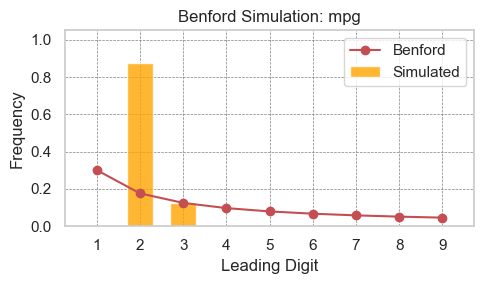

In [40]:
# Get observed frequencies
first_digits = extract_first_digit(Benford_mpg)
observed_counts = pd.Series(first_digits).value_counts().sort_index()
observed_freq = observed_counts.reindex(range(1, 10), fill_value=0) / len(first_digits)

# Calculate stats
chi2S, pvalS, eu_distS = benford_stats(Benford_mpg)

# Plot Benford vs Observed
plt.figure(figsize=(5, 3))
plt.bar(observed_freq.index, observed_freq.values, width=0.6, color='orange', alpha=0.8, label='Simulated')
plt.plot(range(1, 10), benford_distribution(), 'ro-', label="Benford")
plt.xlabel("Leading Digit")
plt.ylabel("Frequency")
plt.title("Benford Simulation: mpg")
plt.xticks(range(1, 10))
plt.ylim(0, 1.05)
plt.legend()
plt.tight_layout()
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.show()

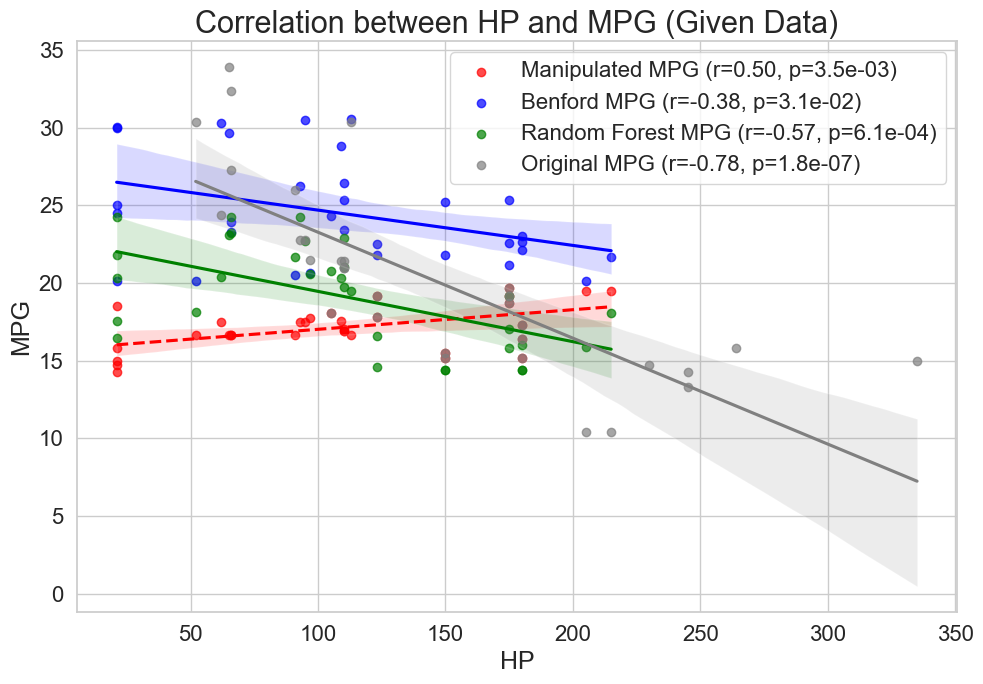

In [42]:

# -----------------------------
# Compute correlations
# -----------------------------
r1, p1 = pearsonr(manipulated['hp'], reversed_predicted_mpg)
r2, p2 = pearsonr(hp, Benford_mpg)
r3, p3 = pearsonr(hp, mpg)
r4, p4 = pearsonr(original_hp, original_mpg)

# -----------------------------
# Plot using sns.regplot
# -----------------------------
plt.figure(figsize=(10, 7))
sns.set(style="whitegrid")

sns.regplot(x=hp, y=mpg, scatter_kws={'color': 'red', 'alpha': 0.7}, line_kws={'color': 'red', 'linestyle': '--'}, label=f"Manipulated MPG (r={r3:.2f}, p={p3:.1e})")
sns.regplot(x=hp, y=Benford_mpg, scatter_kws={'color': 'blue', 'alpha': 0.7}, line_kws={'color': 'blue'}, label=f"Benford MPG (r={r2:.2f}, p={p2:.1e})")
sns.regplot(x=manipulated['hp'], y=reversed_predicted_mpg, scatter_kws={'color': 'green', 'alpha': 0.7}, line_kws={'color': 'green'}, label=f"Random Forest MPG (r={r1:.2f}, p={p1:.1e})")
sns.regplot(x=original_hp, y=original_mpg, scatter_kws={'color': 'gray', 'alpha': 0.7}, line_kws={'color': 'gray'}, label=f"Original MPG (r={r4:.2f}, p={p4:.1e})")

plt.xticks(fontsize=16)  # Increase x-axis tick labels
plt.yticks(fontsize=16)  # Increase y-axis tick labels
plt.xlabel("HP", fontsize=18)
plt.ylabel("MPG", fontsize=18)
plt.title("Correlation between HP and MPG (Given Data)", fontsize=22)
plt.legend(fontsize=16)
plt.tight_layout()
plt.show()